# **Capitulo 4: Introducción a Métodos Autorregresivos y Automatizados para el Pronóstico de Series de Tiempo**

La elaboración de pronósticos es una parte integral de cualquier negocio, ya sea en relación con los ingresos, el inventario, las ventas en línea o la previsión de la demanda de los clientes. La previsión de series de tiempo sigue siendo fundamental porque en el mundo real existen varios problemas y datos relacionados que presentan una dimensión temporal.

Aplicar modelos de aprendizaje automático para acelerar los pronósticos permite la escalabilidad, el rendimiento y la precisión de soluciones inteligentes que pueden mejorar las operaciones comerciales. Sin embargo, la construcción de modelos de aprendizaje automático suele ser consumidora de tiempo y compleja, con muchos factores a considerar, como la iteración a través de algoritmos, la ajuste de hiperparámetros de aprendizaje automático y la aplicación de técnicas de ingeniería de características. Estas opciones se multiplican cuando se trabaja con datos de series de tiempo, ya que los científicos de datos deben tener en cuenta factores adicionales, como las tendencias, la estacionalidad, las festividades y las variables económicas externas.

## **Autoregresión**

Es un método de pronóstico de series de tiempo que depende únicamente de las salidas anteriores de una serie de tiempo. Esta técnica asume que las futuras observaciones en el próximo período de tiempo están relacionadas con las observaciones en períodos anteriores a través de una relación lineal.

En este método, el valor de salida en el período de tiempo anterior se convierte en el valor de entrada para predecir el valor del próximo período de tiempo, y los errores siguen las suposiciones habituales sobre los errores en un modelo de regresión lineal simple. En las autoregresiones, el número de valores de entrada anteriores en la serie de tiempo que se utilizan para predecir el valor del próximo período de tiempo se llama *orden* (a menudo nos referimos al orden con la letra $p$), que determina cuantos puntos de datos anteriores se utilizarán.

El valor de prediccióna actual (salida/output) se basa en el valor inmediatamente anterior (entrada/input) como autoregresión de primer orden, como se ilustra en la Figura 4.1

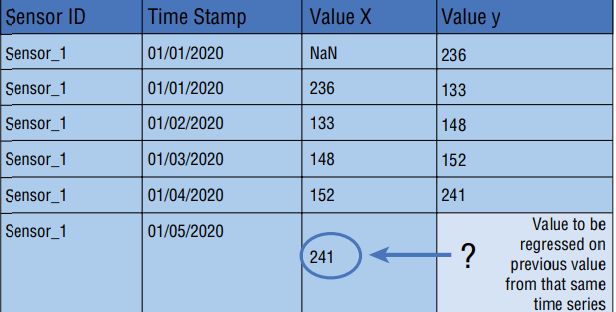

**Figura 4.1:** Enfoque de autoregresión de primer orden.

Para predecir el valor del próximo período de tiempo utilizando los dos valores anteriores en lugar de uno, entonces el enfoque se llama autoregresión de segundo orden.

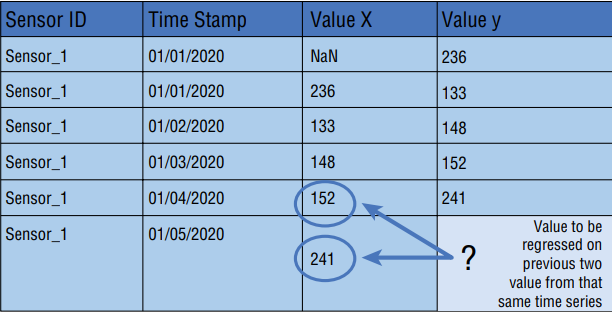

**Figura 4.2:** Enfoque de autoregresión de segundo orden.

De forma general, una autoregresión de orden $n$ es una regresión lineal múltiple en la que el valor de la serie en cualquier momento $t$ es una función lineal de los valores previos en esa misma serie de tiempo. Debido a esta dependencia secuencial, otro aspecto importante de las autoregresiones es la **autocorrelación**, que ocurre cuando una serie de tiempo está relacioanda linealmente con una versión previa o rezagada de sí misma. Entre mayor sea la correlación entre la salida (lo que se necesita predecir) y una variable específica (valores de entrada), mas péso puede poner la autoregresión en esa variable específica.

Algunos métodos de regresión, como la regresión lineal y la regresión de mínimos cuadrados ordinarios, se basan en la suposición implícita de que no hay presencia de autocorrelación en el conjunto de datos de entrenamiento utilizado para alimentar el modelo. Estos métodos se definen como metodologías paramétricas, ya que el conjunto de datos utilizado con ellos presenta una distribución normal y su función de regresión se define en términos de un número finito de parámetros desconocidos que se estiman a partir de los datos. Es por ello que la autocorrelación puede ayudar a seleccionar el método más adecuado para sus soluciones de pronóstico de series de tiempo; también, puede ser muy útil para obtener información adicional de los datos y entre sus variables, y para identificar patrones ocultos, como la estacionalidad y la tendencia en los datos de series de tiempo. 

Para verificar si existe autocorrelación en datos de series de tiempo, se puede utilizar dos gráficos incorporados proporcionados por pandas, llamados `lag_plot` y `autocorrelation_plot`. Estas funciones se pueden importar desde pandas.plotting y toman una Serie o un DataFrame como argumento. Ambos gráficos son verificaciones visuales que puede utilizar para ver si hay autocorrelación en su conjunto de datos de series de tiempo.

**Tabla 4.1:** Referencia y descripción de la API pandas.plotting.lag_plot

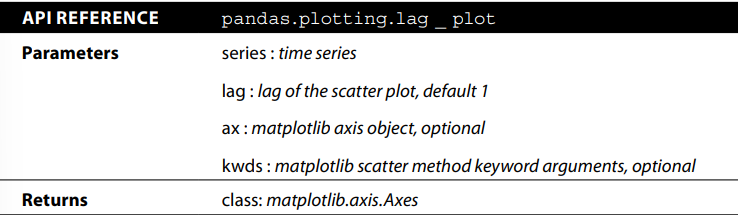

A continuación se muestra un ejemplo de cómo crear un gráfico de retraso para el conjunto ts_data_load. Primero, se importan las librerías necesarias y se cargan los datos en un DataFrame.


In [9]:
import zipfile
import os
import sys
import pandas as pd

# This function unzips the GEFCom2014 data zip file and extracts the 'extended'
# load forecasting competition data. Data is saved in energy.csv
def extract_data(data_dir):
    GEFCom_dir = os.path.join(data_dir, 'GEFCom2014', 'GEFCom2014 Data')

    GEFCom_zipfile = os.path.join(data_dir, 'GEFCom2014.zip')
    if not os.path.exists(GEFCom_zipfile):
        sys.exit("Download GEFCom2014.zip from https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0 and save it to the '{}' directory.".format(data_dir))

    # unzip root directory
    zip_ref = zipfile.ZipFile(GEFCom_zipfile, 'r')
    zip_ref.extractall(os.path.join(data_dir, 'GEFCom2014'))
    zip_ref.close()

    # extract the extended competition data
    zip_ref = zipfile.ZipFile(os.path.join(GEFCom_dir, 'GEFCom2014-E_V2.zip'), 'r')
    zip_ref.extractall(os.path.join(data_dir, 'GEFCom2014-E'))
    zip_ref.close()

    # load the data from Excel file
    data = pd.read_excel(os.path.join(data_dir, 'GEFCom2014-E', 'GEFCom2014-E.xlsx'), parse_dates= True)
    # data = pd.read_excel(os.path.join(data_dir, 'GEFCom2014-E', 'GEFCom2014-E.xlsx'), parse_date='Date')

    # create timestamp variable from Date and Hour
    data['timestamp'] = data['Date'].add(pd.to_timedelta(data.Hour - 1, unit='h'))
    data = data[['timestamp', 'load', 'T']]
    data = data.rename(columns={'T':'temp'})

    # remove time period with no load data
    data = data[data.timestamp >= '2012-01-01']

    # save to csv
    data.to_csv(os.path.join(data_dir, 'energy.csv'), index=False)

import numpy as np
import pandas as pd
import os
from collections import UserDict

def load_data(data_dir):
    """Load the GEFCom 2014 energy load data"""

    energy = pd.read_csv(os.path.join(data_dir, 'energy.csv'), parse_dates=['timestamp'])

    # Reindex the dataframe such that the dataframe has a record for every time point
    # between the minimum and maximum timestamp in the time series. This helps to 
    # identify missing time periods in the data (there are none in this dataset).

    energy.index = energy['timestamp']
    energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                                          max(energy['timestamp']),
                                          freq='H'))
    energy = energy.drop('timestamp', axis=1)

    return energy


def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()


def create_evaluation_df(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, H+1)])
    eval_df['timestamp'] = test_inputs.dataframe.index
    eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
    eval_df['actual'] = np.transpose(test_inputs['target']).ravel()
    eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
    return eval_df


class TimeSeriesTensor(UserDict):
    """A dictionary of tensors for input into the RNN model.
    
    Use this class to:
      1. Shift the values of the time series to create a Pandas dataframe containing all the data
         for a single training example
      2. Discard any samples with missing values
      3. Transform this Pandas dataframe into a numpy array of shape 
         (samples, time steps, features) for input into Keras

    The class takes the following parameters:
       - **dataset**: original time series
       - **target** name of the target column
       - **H**: the forecast horizon
       - **tensor_structures**: a dictionary discribing the tensor structure of the form
             { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
             if features are non-sequential and should not be shifted, use the form
             { 'tensor_name' : (None, [feature, feature, ...])}
       - **freq**: time series frequency (default 'H' - hourly)
       - **drop_incomplete**: (Boolean) whether to drop incomplete samples (default True)
    """
    
    def __init__(self, dataset, target, H, tensor_structure, freq='H', drop_incomplete=True):
        self.dataset = dataset
        self.target = target
        self.tensor_structure = tensor_structure
        self.tensor_names = list(tensor_structure.keys())
        
        self.dataframe = self._shift_data(H, freq, drop_incomplete)
        self.data = self._df2tensors(self.dataframe)
    
    def _shift_data(self, H, freq, drop_incomplete):
        
        # Use the tensor_structures definitions to shift the features in the original dataset.
        # The result is a Pandas dataframe with multi-index columns in the hierarchy
        #     tensor - the name of the input tensor
        #     feature - the input feature to be shifted
        #     time step - the time step for the RNN in which the data is input. These labels
        #         are centred on time t. the forecast creation time
        df = self.dataset.copy()
        
        idx_tuples = []
        for t in range(1, H+1):
            df['t+'+str(t)] = df[self.target].shift(t*-1, freq=freq)
            idx_tuples.append(('target', 'y', 't+'+str(t)))

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            dataset_cols = structure[1]
            
            for col in dataset_cols:
            
            # do not shift non-sequential 'static' features
                if rng is None:
                    df['context_'+col] = df[col]
                    idx_tuples.append((name, col, 'static'))

                else:
                    for t in rng:
                        sign = '+' if t > 0 else ''
                        shift = str(t) if t != 0 else ''
                        period = 't'+sign+shift
                        shifted_col = name+'_'+col+'_'+period
                        df[shifted_col] = df[col].shift(t*-1, freq=freq)
                        idx_tuples.append((name, col, period))
                
        df = df.drop(self.dataset.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        df.columns = idx

        if drop_incomplete:
            df = df.dropna(how='any')

        return df
    
    def _df2tensors(self, dataframe):
        
        # Transform the shifted Pandas dataframe into the multidimensional numpy arrays. These
        # arrays can be used to input into the keras model and can be accessed by tensor name.
        # For example, for a TimeSeriesTensor object named "model_inputs" and a tensor named
        # "target", the input tensor can be acccessed with model_inputs['target']
    
        inputs = {}
        y = dataframe['target']
        y = y.as_matrix()
        inputs['target'] = y

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            cols = structure[1]
            tensor = dataframe[name][cols].as_matrix()
            if rng is None:
                tensor = tensor.reshape(tensor.shape[0], len(cols))
            else:
                tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
                tensor = np.transpose(tensor, axes=[0, 2, 1])
            inputs[name] = tensor

        return inputs
       
    def subset_data(self, new_dataframe):
        
        # Use this function to recreate the input tensors if the shifted dataframe
        # has been filtered.
        
        self.dataframe = new_dataframe
        self.data = self._df2tensors(self.dataframe)

In [10]:
# download ts_data set
# change the name of the directory with your folder name
data_dir = './energy'
if not os.path.exists(os.path.join(data_dir, 'energy.csv')):
 # download and move the zip file
 !wget https://mlftsfwp.blob.core.windows.net/mlftsfwp/GEFCom2014.zip
 !mv GEFCom2014.zip ./energy
 # if not done already, extract zipped data and save as csv
 extract_data(data_dir)

In [11]:
# Import necessary libraries
import datetime as dt
import os
import warnings
from collections import UserDict
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
%matplotlib inline
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")
# Load the data from csv into a pandas dataframe
ts_data_load = load_data(data_dir)[['load']]

Ahora, creamos un gráfico de retraso para el conjunto ts_data_load, seleccionando solo la carga columna:

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

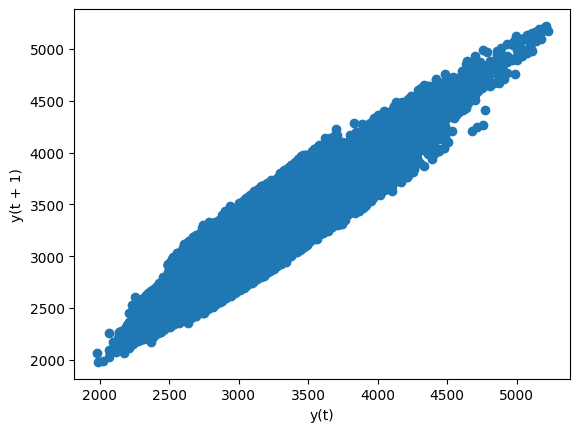

In [12]:
# Import lag_plot function
from pandas.plotting import lag_plot
plt.figure()
# Pass the lag argument and plot the values.
# When lag=1 the plot is essentially data[:-1] vs. data[1:]
# Plot our ts_data_load set
lag_plot(ts_data_load)

Esos gráficos de retardo de utilizan para comprobar que un conjunto de datos o una serie de tiempo es aleatorio. En la gráfica anterior se puede ver una línea diagonal, lo cuál muestra una relación o cierta correlación entre esas observaciones.

**Tabla 4.2:** Referencia y descripción de la API pandas.plotting.lag_plot 

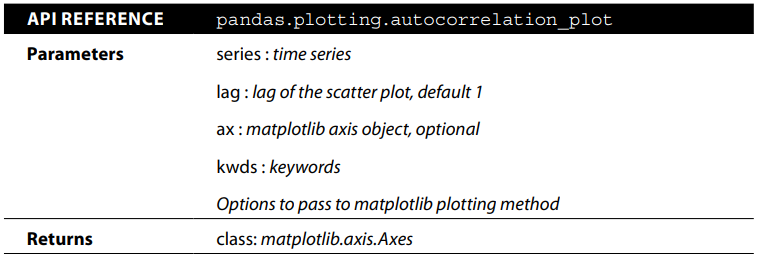

Los gráficos de autocorrelación son utilizados para verificar la aleatoriedad en las series de tiempo mediante el cálculo de las autocorrelaciones de los valores de datos en retrasos de tiempo fluctuantes. Si la serie de tiempo es aleatoria, los valores de autocorrelación deberían estar cerca de cero para todos los retrasos de tiempo. Si la serie de tiempo no es aleatoria, entonces uno o más de los valores de autocorrelación serán significativamente distintos de cero.

Se muestra un ejemplo de cómo crear un gráfico de autocorrelación para el conjunto de datos de series de tiempo llamado "ts_data_load".

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

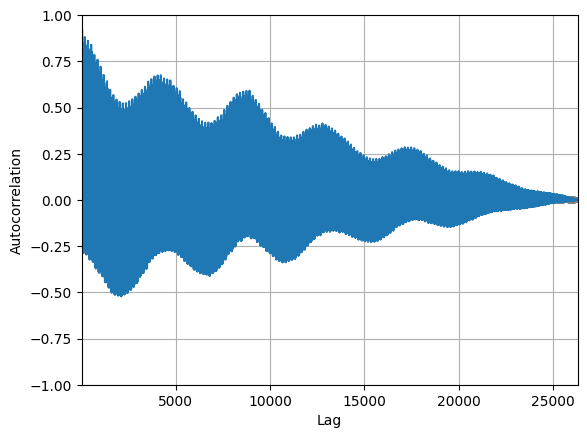

In [13]:
# Import autocorrelation_plot function
from pandas.plotting import autocorrelation_plot
plt.figure()
# Pass the autocorrelation argument and plot the values
autocorrelation_plot(ts_data_load)

Por la cantidad de datos que se tienen en ts_data_load, se selecciona un subconjunto de datos para ver las líneas horizontaes que deberían aparecer en el gráfico de autocorrelación y se aplica nuevamente la función.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

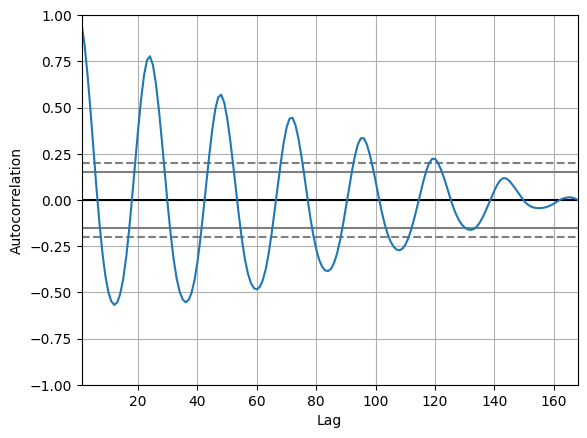

In [14]:
# Create subset
ts_data_load_subset = ts_data_load['2014-08-01':'2014-08-07']
# Import autocorrelation _plot function
from pandas.plotting import autocorrelation_plot
plt.figure()
# Pass the autocorrelation argument and plot the values
autocorrelation_plot(ts_data_load_subset)

El gráfico de autocorrelación muestra el valor de la función de autocorrelación en el eje vertical, que puede variar de -1 a 1.  Las líneas horizontales mostradas en el gráfico corresponden a bandas de confianza del 95% y del 99%, y la línea punteada es la banda de confianza del 99 por ciento. El gráfico de autocorrelación tiene como objetivo revelar si los puntos de datos de una serie de tiempo están positivamente correlacionados, negativamente correlacionados o son independientes entre sí.

Un gráfico de la autocorrelación de una serie de tiempo en función del retraso también se llama función de autocorrelación (ACF). Python admite la ACF con la función `plot_acf()` de la biblioteca statsmodels. A continuación, se muestra un ejemplo de cómo calcular y graficar el gráfico de autocorrelación para el conjunto de datos ts_data_load utilizando la función `plot_acf()`.

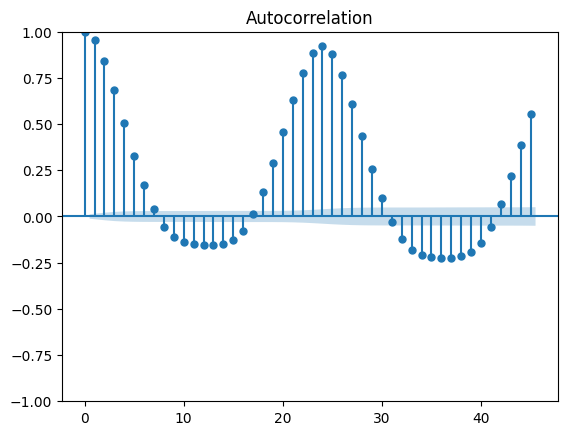

In [15]:
# Import plot_acf() function
from statsmodels.graphics.tsaplots import plot_acf
# Plot the acf function on the ts_data_load set
plot_acf(ts_data_load)
plt.show()

Ahora para el subconjunto de datos.

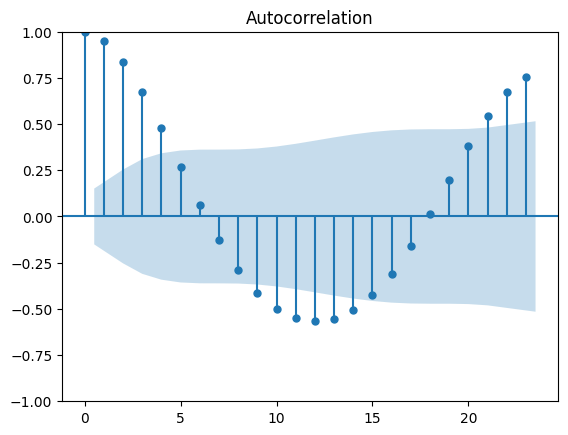

In [16]:
# Import plot_acf() function
from statsmodels.graphics.tsaplots import plot_acf
# Plot the acf function on the ts_data_load_subset
plot_acf(ts_data_load_subset)
plt.show()

Las ilustraciones anteriores muestran intervalos de confianza trazados en forma de cono. Por defecto, esto se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este cono son muy probablemente una correlación.

Otro concepto importante a considerar es la función de correlación parcial (PACF), que es la correlación entre dos variables bajo la suposición de que consideramos los valores de algún otro conjunto de variables. En la regresión, esta correlación parcial se puede encontrar correlacionando los residuos de dos regresiones diferentes.

En un conjunto de datos de series de tiempo, la autocorrelación para un valor en un período de tiempo y otro valor en un período de tiempo anterior consiste tanto en la correlación directa entre estos dos valores como en correlaciones indirectas. Estas correlaciones indirectas son una función lineal de la correlación del valor bajo observación con los valores en períodos de tiempo intermedios.

Python admite la función PACF con `plot_pacf()`. El ejemplo a continuación calcula y grafica una función de autocorrelación parcial para los primeros 20 retrasos de los datos ts_data_load.

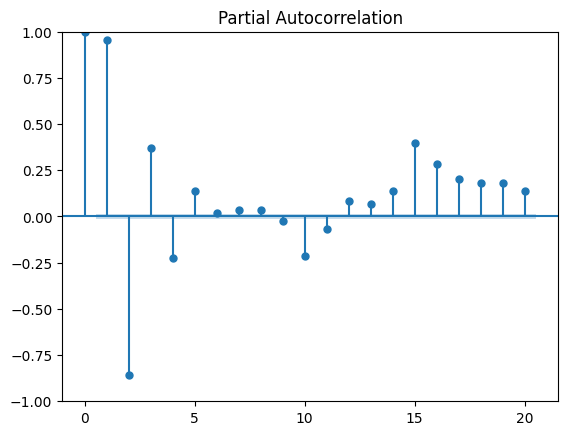

In [17]:
# Import plot_pacf() function
from statsmodels.graphics.tsaplots import plot_pacf
# Plot the pacf function on the ts_data_load dataset
plot_pacf(ts_data_load, lags=20)
plt.show()

Los conceptos y las respectivas gráficas de las funciones ACF y PACF se vuelven particularmente importantes cuando se necesita comprender y determinar el orden de los métodos de series de tiempo autorregresivas y de media móvil. Hay dos métodos que se pueden utilizar para identificar el orden de un modelo AR(p):

- Las funciones ACF y PACF
- Los criterios de información

Como se ilustra en el gráfico anterior, la ACF es una función de autocorrelación que proporciona información sobre cuánto una serie está autocorrelacionada con sus valores rezagados, es decir, cuán relacionado está el valor presente de la serie con sus valores pasados.

Por otro lado, la PACF es otra función importante que encuentra la correlación entre los residuos y el siguiente rezago. Mide el beneficio incremental de agregar otro rezago. Entonces, si a través de la función PACF se descubre que hay información oculta en los residuos que puede ser modelada por el siguiente rezago, se podría obtener una buena correlación y mantendrá ese próximo rezago como característica al modelar.

Para evitar características multicolineales en los modelos de series de tiempo, es necesario encontrar características óptimas u orden del proceso de autorregresión utilizando la gráfica PACF, ya que elimina las variaciones explicadas por rezagos anteriores, de modo que obtenemos solo las características relevantes. Observe que una buena correlación positiva con los rezagos hasta el rezago número 6; este es el punto en el que la gráfica de ACF corta el umbral de confianza superior. Aunque tenemos se tiene buena correlación hasta el sexto rezago, no se puede usar todos ellos, ya que crearía un problema de multicolinealidad; por eso se recurre a la gráfica PACF para obtener solo los rezagos más relevantes.

El siguiente ejemplo calcula y representa gráficamente una función de autocorrelación parcial para los primeros 30 retrasos del subconjunto de datos "ts_data_load".

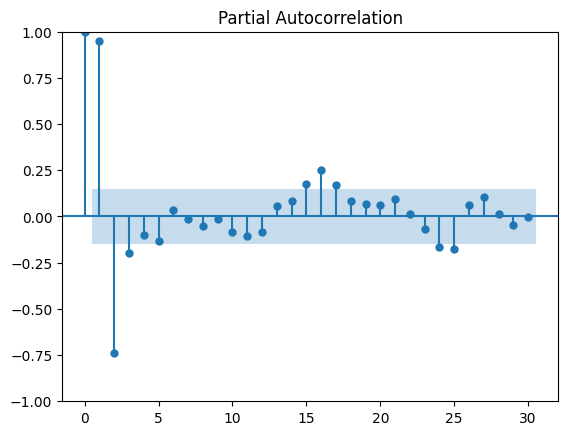

In [18]:
# plot the pacf function on the ts_data_load_subset
plot_pacf(ts_data_load_subset, lags=30)
plt.show()

En el gráfico anterior, los rezagos hasta 6 tienen buena correlación antes de que la gráfica corte por primera vez el intervalo de confianza superior. Este es el valor p, que es el orden del proceso de autorregresión. Se puede modelar el proceso de autorregresión dado utilizando una combinación lineal de los primeros 6 rezagos. También se puede ver que los rezagos hasta 1 tienen buena correlación antes de que la gráfica corte por primera vez el intervalo de confianza superior. Este es el valor p, el orden del proceso de autorregresión. Luego se puede modelar este proceso de autorregresión utilizando el primer rezago.

Cuanto más rezagos se incluyan en el modelo, mejor se ajustará el modelos; sin embargo, esto también puede representar un riesgo de sobreajuste. Los criterios de información ajustan la bondad del ajuste de un modelo imponiendo una penalización basada en el número de parámetros utilizados. Hay dos medidas populares de bondad de ajuste ajustadas:

- AIC
- BIC

Para obtener la información de estas dos medidas, se usa la función `summary()`, el atributo params o los atributos aic y bic en Python. 

**Tabla 4.3:** : Clase autorregresiva en statsmodels.

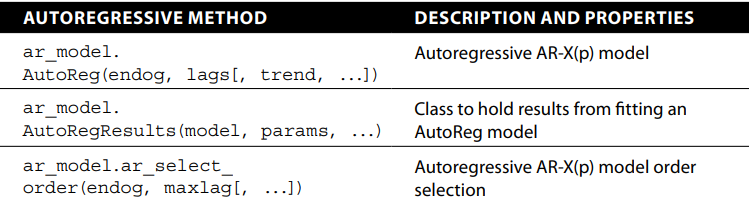

El modelo `ar_model.AutoReg` estima parámetros mediante:

- *Estimador de máxima verosimilitud condicional (CML)*: Implica la maximización de una función de log-verosimilitud condicional, en la cual los parámetros tratados como conocidos son fijados mediante suposiciones teóricas o, más comúnmente, reemplazados por estimaciones.

Además, este modelo admite los siguientes elementos:

- *Regresores exógenos (variables independientes)*: Tienen un efecto en los valores de la variable objetivo. En particular, el modelo `AR-X(p)` permite la inclusión de estos regresores.

- *Efectos estacionales*: Patrones sistemáticos y relacionados con el calendario en series de tiempo.

Python usa `AutoReg`de la librery stastmodels para modelar la autoregresión. (Más información en: statsmodels.org/stable/generated/statsmodels.tsa
.ar_model.AutoReg.html)


**Tabla 4.4:** Definición y parámetros de clase autorregresiva en statmodels models

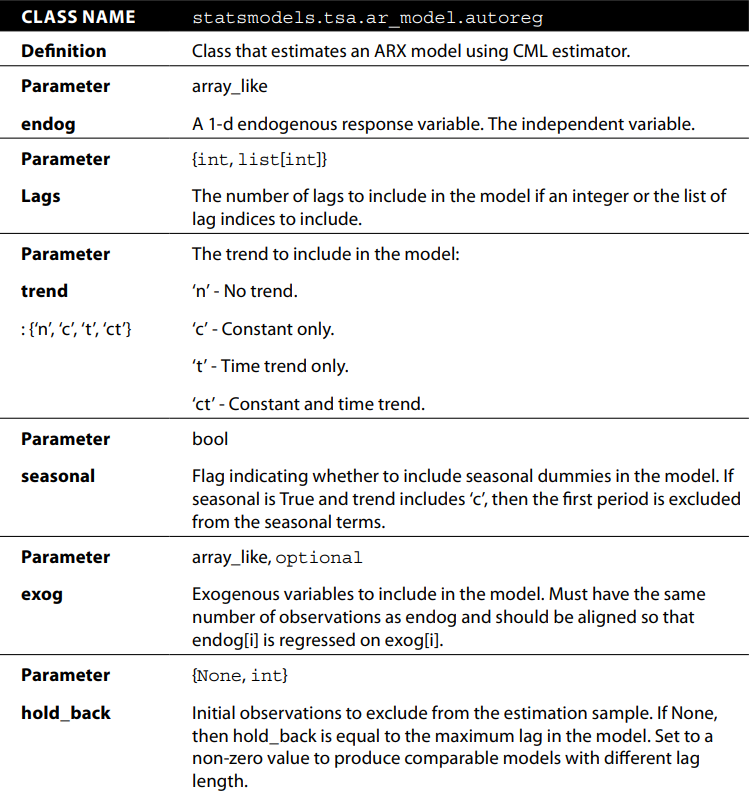
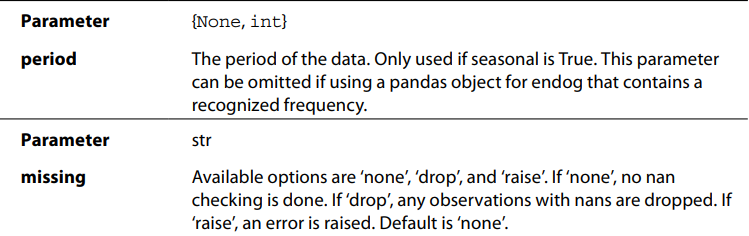

In [19]:
# Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
# Apply AutoReg model
model = AutoReg(ts_data_load, 1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   load   No. Observations:                26304
Model:                     AutoReg(1)   Log Likelihood             -171639.978
Method:               Conditional MLE   S.D. of innovations            165.100
Date:                Thu, 12 Oct 2023   AIC                         343285.956
Time:                        20:35:49   BIC                         343310.488
Sample:                    01-01-2012   HQIC                        343293.877
                         - 12-31-2014                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.5181      6.043     23.913      0.000     132.673     156.363
load.L1        0.9563      0.002    530.344      0.000       0.953       0.960
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0457           +0.0000j            1.0457            0.0000
-----------------------------------------------------------------------------
"""

AutoReg admite los mismos estimadores de covarianza que los modelos de Mínimos Cuadrados Ordinarios (OLS). A continuación, se utiliza `cov_type = "HC0"`, que es el estimador de covarianza de White. La prueba de White se utiliza para detectar errores heterocedásticos en el análisis de regresión: la hipótesis nula de la prueba de White es que las varianzas de los errores son iguales. Todas las cantidades que dependen del error estándar cambian. En el siguiente ejemplo, se muestra cómo aplicar los estimadores de covarianza `cov_type = "HC0"` y generar un resumen de los resultados.

In [20]:
# Apply covariance estimators cov_type="HC0" and output the summary
res = model.fit(cov_type="HC0")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   load   No. Observations:                26304
Model:                     AutoReg(1)   Log Likelihood             -171639.978
Method:               Conditional MLE   S.D. of innovations            165.100
Date:                Thu, 12 Oct 2023   AIC                         343285.956
Time:                        20:35:49   BIC                         343310.488
Sample:                    01-01-2012   HQIC                        343293.877
                         - 12-31-2014                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.5181      5.364     26.945      0.000     134.006     155.030
load.L1        0.9563      0.002    618.131      0.000       0.953       0.959
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0457           +0.0000j            1.0457            0.0000
-----------------------------------------------------------------------------
"""

Al utilizar `plot_predict` se puede visualizar las previsiones.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


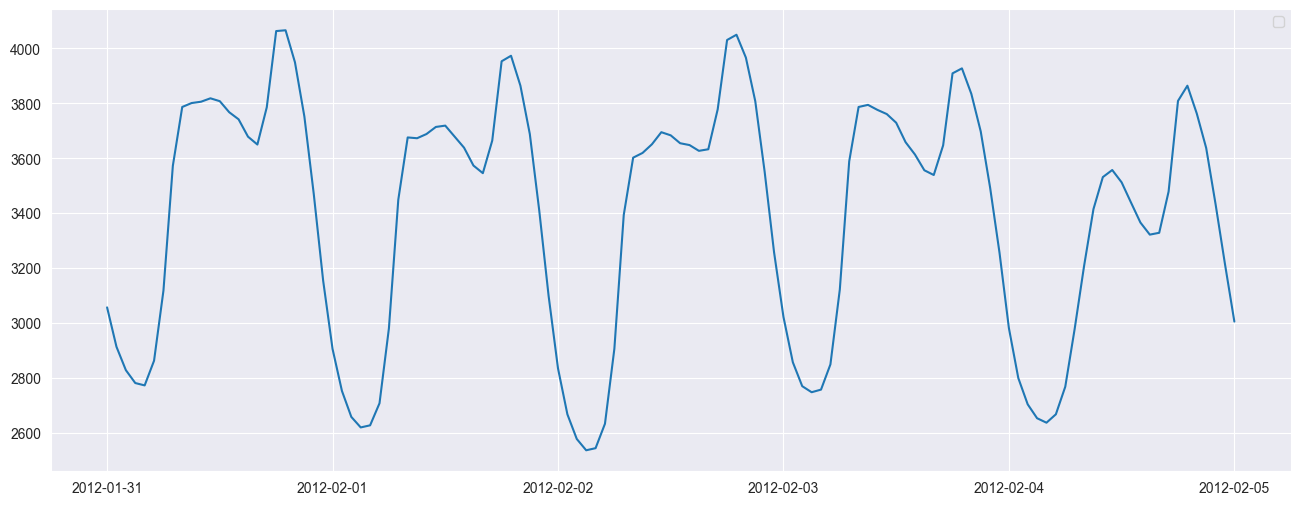

In [21]:
# Define figure style, plot package and default figure size
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
# Use plot_predict and visualize forecasts
figure = results.plot_predict(720, 840)

`plot_diagnostics` indica que el modelo captura las características clave en los datos.

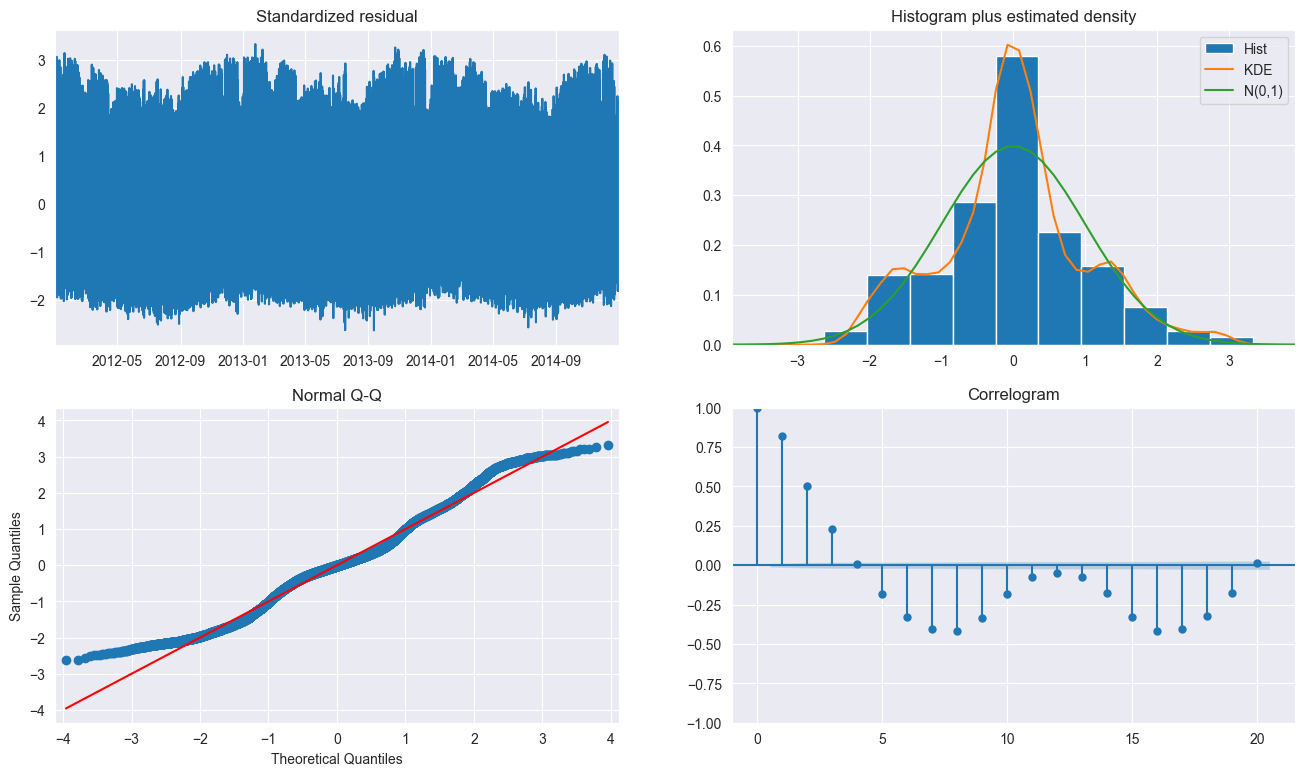

In [22]:
# Define default figure size
fig = plt.figure(figsize=(16,9))
# Use plot_predict and visualize forecasts
fig = res.plot_diagnostics(fig=fig, lags=20)

Finalmente, se puede probar la capacidad de pronóstico de la función `AutoReg()`. Se generan pronósticos utilizando el método "predict" a partir de una instancia de resultados. El valor predeterminado produce pronósticos estáticos, que son pronósticos de un paso. Para generar pronósticos de múltiples pasos, es necesario utilizar `dynamic=True`.

Aplicamos el método `predict` al conjunto de datos ts_data. La preparación de datos para el conjunto de entrenamiento implica los siguientes pasos:

1. Definir la fecha de inicio para los conjuntos de entrenamiento y prueba.


In [23]:
# Define the start date for the train and test sets
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

2. Filtrar el conjunto de datos original para incluir solo el período de tiempo reservado para el conjunto de entrenamiento.

In [24]:
# Create train set containing only the model features
train = ts_data_load.copy()[
    (ts_data_load.index >= train_start_dt)
    & (ts_data_load.index < test_start_dt)][['load']]
test = ts_data_load.copy()[
    ts_data_load.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


3. Escalar la serie de tiempo de manera que los valores caigan dentro del intervalo (0, 1) utilizando `MinMaxScaler`

In [25]:
# Scale train data to be in range (0, 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head()
# Scale test data to be in range (0, 1)
test['load'] = scaler.transform(test)
test.head()


,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


También se especifica el número de pasos a pronosticar hacia adelante.

In [26]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


Ahora se crear un punto de datos de prueba para cada horizonte.

In [27]:
# Create a test data point for each HORIZON
test_shifted = test.copy()
for t in range(1, HORIZON):
 test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2
2014-12-30 00:00:00,0.33,0.29,0.27
2014-12-30 01:00:00,0.29,0.27,0.27
2014-12-30 02:00:00,0.27,0.27,0.30
2014-12-30 03:00:00,0.27,0.30,0.41
2014-12-30 04:00:00,0.30,0.41,0.57


Finalmente, se usa `predict` para hacer predicciones en el conjunto de prueba.

In [28]:
%%time
# Make predictions on the test data
training_window = 720
train_ts = train['load']
test_ts = test_shifted
history = [x for x in train_ts]
history = history[(-training_window):]
predictions = list()
for t in range(test_ts.shape[0]):
 model = AutoReg(ts_data_load, 1)
 model_fit = model.fit()
 yhat = model_fit.predict
 predictions.append(yhat)
 obs = list(test_ts.iloc[t])
 # move the training window
 history.append(obs[0])
 history.pop(0)
 print(test_ts.index[t])
 print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x00000269A36EC910>> expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x00000269A36EF340>> expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x00000269A36EF3D0>> expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = <bound method AutoRegResults.predict of <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x00000269A36EDC30>> expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = <bound method AutoRegResults.predict of <statsmodel

## **Media móvil**

La técnica del promedio móvil aprovecha los errores de pronóstico anteriores en un enfoque de regresión para pronosticar futuras observaciones en los próximos momentos de tiempo: se puede pensar en cada observación futura como un promedio móvil ponderado de los errores de pronóstico previos.

Junto con la técnica de autorregresión, el enfoque de promedio móvil es un elemento importante de los modelos autoregresivos de media móvil y los modelos autoregresivos de media móvil integrados, que presentan una configuración estocástica más sofisticada.

Los modelos de media móvil son muy similares a los modelos autorregresivos, ya que los modelos autorregresivos representan una combinación lineal de observaciones pasadas, mientras que los modelos de media móvil representan una combinación de términos de error pasados. Son muy buenos para explicar patrones ocultos o irregulares en el proceso de error directamente mediante el ajuste de un modelo a los términos de error.

Python admite el enfoque del promedio móvil a través de la clase ARMA (AutoRegressive Moving Average) de la biblioteca statsmodels. Esto se logra estableciendo el orden del modelo autorregresivo en 0 y definiendo el orden del modelo de promedio móvil en el argumento `order`. 

`MovAvg_Model = ARMA(ts_data_load, order=(0, 1))` 

La librería statsmodels ofrece la definición y parámetros para la clase ARMA() que se muestran en la Tabla 4.5.

**Tabla 4.5:** Media móvil autorregresiva en modelos de estadísticas 
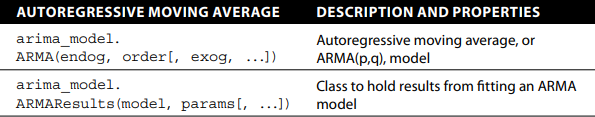

## **Media móvil autorregresiva**

Los modelos autorregresivos de media móvil (ARMA) siempre han desempeñado un papel fundamental en la modelización de series de tiempo, ya que su estructura lineal contribuye a una sustancial simplificación de la predicción lineal (Zhang et al., 2015).

Un método ARMA consta de dos partes:
- Una autorregresión
- Un modelo de media móvil

En comparación con los modelos autorregresivos y de media móvil, los modelos ARMA proporcionan el modelo lineal más eficiente de series temporales estacionarias, ya que son capaces de modelar el proceso desconocido con el menor número de parámetros.

En particular, los modelos ARMA se utilizan para describir series de tiempo estocásticas estacionarias en términos de dos polinomios. El primero de estos polinomios es para la autorregresión, y el segundo para el promedio móvil. A menudo, este método se denomina modelo ARMA(p, q), en el que:

- "p" representa el orden del polinomio autorregresivo.
- "q" representa el orden del polinomio de media móvil.

Python admite la implementación del modelo ARMA con la función `ARMA()` (statsmodels.tsa.arima_model.ARMA) de la biblioteca statsmodels. La biblioteca statsmodels ofrece la definición y los parámetros para la clase ARMA(), que se muestran en la Tabla 4.6.

**Tabla 4.6:** Definición y parámetros de la clase de media móvil autorregresiva en modelos estadísticos
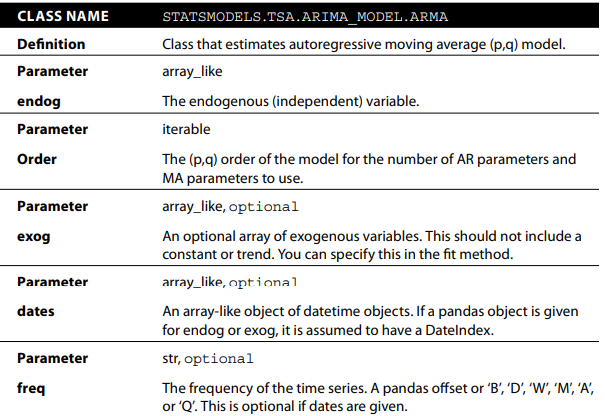



## **Media móvil integrada autorregresiva**

Los modelos autoregresivos de media móvil integrada (ARIMA) se consideran un desarrollo de los modelos más simples de autoregresión y media móvil (ARMA) e incluyen la noción de integración.

De hecho, los modelos de autoregresión y media móvil (ARMA) y los modelos autoregresivos de media móvil integrada (ARIMA) presentan muchas características similares: sus elementos son idénticos en el sentido de que ambos aprovechan una autorregresión general AR(p) y un modelo general de media móvil MA(q). Como aprendió anteriormente, el modelo AR(p) hace predicciones utilizando valores anteriores en la serie de tiempo, mientras que MA(q) hace predicciones utilizando la media de la serie y los errores anteriores.

Las principales diferencias entre los métodos ARMA y ARIMA son las nociones de integración y diferenciación. Un modelo ARMA es un modelo estacionario y funciona muy bien con series de tiempo estacionarias (cuyas propiedades estadísticas, como la media, la autocorrelación y la estacionalidad, no dependen del momento en que se ha observado la serie).

Es posible estacionarizar una serie de tiempo mediante técnicas de diferenciación. El proceso de estimar cuántas diferencias no estacionales son necesarias para que una serie temporal sea estacionaria se llama integración (I) o método integrado.

Los modelos ARIMA tienen tres componentes principales, denotados como p, d, q. En Python, puede asignar valores enteros a cada uno de estos componentes para indicar el modelo ARIMA específico que necesita aplicar. Estos parámetros se definen de la siguiente manera:

- "p" representa el número de variables rezagadas incluidas en el modelo ARIMA, también llamado orden de rezago.
- "d" representa el número de veces que se diferencian los valores brutos en un conjunto de datos de series temporales, también llamado grado de diferenciación.
- "q" denota la magnitud de la ventana de media móvil, también llamado orden de media móvil.

En el caso de que uno de los parámetros anteriores no sea necesario, se puede asignar un valor de 0 a ese parámetro específico, lo que indica que no se debe utilizar ese elemento del modelo.

Python admite la clase SARIMAX() con la biblioteca statsmodels (statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html), como se resume en la Tabla 4.7.

**Tabla 4.7:** Media móvil integrada auto regresiva estacional con factores exógenos
en modelos de estadísticas
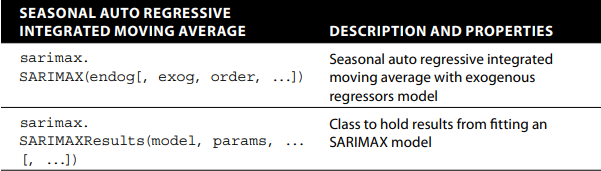

La biblioteca statsmodels ofrece la definición y los parámetros para `SARIMAX()`
clase que se muestra en la Tabla 4.8.

**Tabla 4.8:** Definición y parámetros de la media móvil integrada autoregresiva estacional
clase en modelos de estadísticas

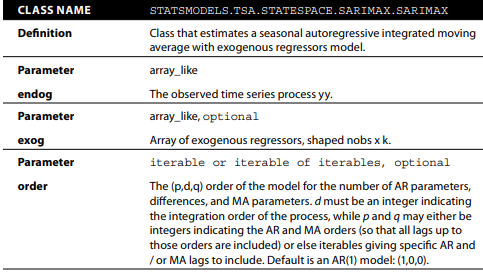
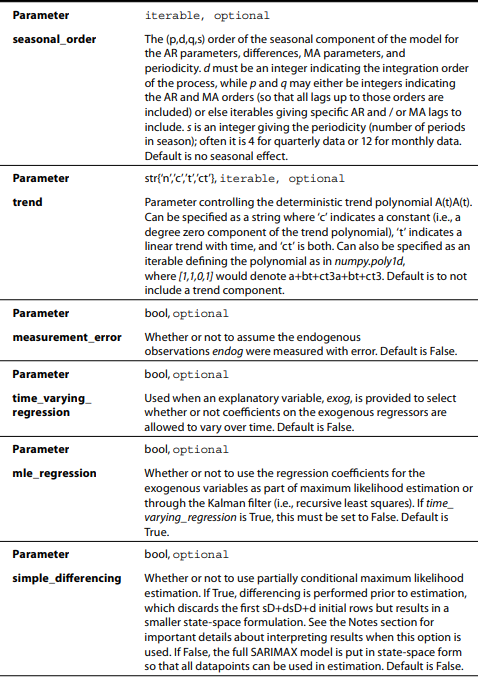
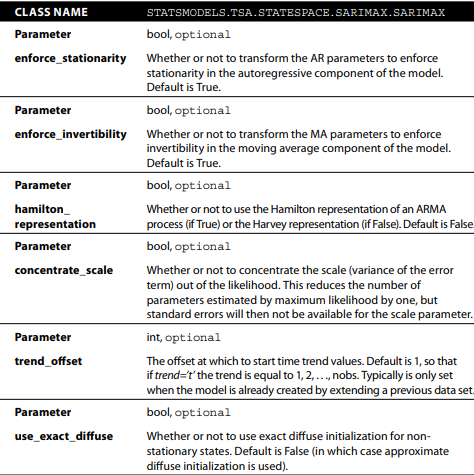

Las librerías para aplicar el modelo SARIMAX son:

In [29]:
# Import necessary libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import math

Ahora se necesita dividir el conjunto de datos en conjuntos de entrenamiento y prueba. Se asegura de que el conjunto de prueba cubra un período posterior en el tiempo al conjunto de entrenamiento, para garantizar que el modelo no se beneficie de información de períodos de tiempo futuros.

ASe asigna el período del 1 de septiembre al 31 de octubre de 2014 al conjunto de entrenamiento (dos meses) y el período del 1 de noviembre de 2014 al 31 de diciembre de 2014 al conjunto de prueba (dos meses). Dado que se trata del consumo diario de energía, hay un patrón estacional fuerte, pero el consumo es más similar al consumo de los días recientes. Por lo tanto, el uso de una ventana de tiempo relativamente pequeña para entrenar los datos debería ser suficiente.

In [30]:
train = ts_data_load.copy()[
    (ts_data_load.index >= train_start_dt) &
    (ts_data_load.index < test_start_dt)
][['load']]

test = ts_data_load.copy()[
    ts_data_load.index >= test_start_dt
][['load']]

print('Train data shape:', train.shape)
print('Test data shape:', test.shape)

Train data shape: (1416, 1)
Test data shape: (48, 1)


La preparación de datos para los conjuntos de entrenamiento y prueba también implica escalar la serie de tiempo de manera que los valores se encuentren en el intervalo (0, 1).

In [31]:
# Scale train data to be in range (0, 1)
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head()
# Scale test data to be in range (0, 1)
test['load'] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


Es importante especificar el número de pasos a pronosticar hacia adelante, así como el orden y el orden estacional para nuestro modelo SARIMAX. Estos parámetros son esenciales para configurar el modelo y realizar pronósticos precisos.

In [32]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


Luego, se especifica el orden y el orden estacional para el modelo SARIMAX.

In [33]:
# Define the order and seasonal order for the SARIMAX model
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

Finalmente, se construye y ajusta el modelo.

In [34]:
# Build and fit the SARIMAX model
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.241
Date:                            Thu, 12 Oct 2023   AIC                          -6942.481
Time:                                    20:36:02   BIC                          -6911.055
Sample:                                11-01-2014   HQIC                         -6930.730
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8407      0.016     52.115      0.000       0.809       0.872
ar.L2         -0.5227      0.034   

Ahora se realiza la validación de avance continuo. En la práctica, los modelos de series de tiempo se vuelven a entrenar cada vez que se dispone de nuevos datos. Esto permite que el modelo realice el mejor pronóstico en cada paso de tiempo.

Comenzando al principio de la serie de tiempo, se entrena el modelo en el conjunto de datos de entrenamiento. Luego se hace una predicción en el siguiente paso de tiempo. La predicción se evalúa frente al valor conocido. El conjunto de entrenamiento se amplía para incluir el valor conocido y se repite el proceso. 

Este proceso proporciona una estimación más robusta de cómo el modelo se desempeñará en la práctica. Sin embargo, conlleva el costo computacional de crear tantos modelos. Esto es aceptable si los datos son pequeños o si el modelo es simple, pero puede ser un problema a mayor escala.

La validación de avance continuo es el estándar de oro en la evaluación de modelos de series de tiempo y se recomienda para sus propios proyectos.

In [35]:
# Create a test data point for each HORIZON step
test_shifted = test.copy()
for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')

We can make predictions on the test data and use a simpler model (by
specifying a different order and seasonal order) for demonstration:

In [36]:
%%time
# Make predictions on the test data
training_window = 720
train_ts = train['load']
test_ts = test_shifted
history = [x for x in train_ts]
history = history[(-training_window):]
predictions = list()
# Let's user simpler model
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)
for t in range(test_ts.shape[0]):
 model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
 model_fit = model.fit()
 yhat = model_fit.forecast(steps = HORIZON)
 predictions.append(yhat)
 obs = list(test_ts.iloc[t])
 # move the training window
 history.append(obs[0])
 history.pop(0)
 print(test_ts.index[t])
 print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

Se comparan las prediccions con los datos reales.

In [37]:
# Compare predictions to actual load
eval_df = pd.DataFrame(predictions,columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp',
value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])

También es útil calcular el error porcentual absoluto medio (MAPE),
que mide el tamaño del error en términos porcentuales sobre todas las predicciones.

In [38]:
# Compute the mean absolute percentage error (MAPE)
if(HORIZON > 1):
 eval_df['APE'] = (eval_df['prediction'] -
 eval_df['actual']).abs() / eval_df['actual']
 print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
Name: APE, dtype: float64


Para ver los resultados de MAPE, se muestra tanto el pronóstico de un paso
Resultado MAPE y resultado MAPE de pronóstico de varios pasos:

In [39]:
# Print one-step forecast MAPE
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h']== 't+1']['prediction'],
eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')
# Print multi-step forecast MAPE
print('Multi-step forecast MAPE: ',
mape(eval_df['prediction'], eval_df['actual'])*100, '%')

One step forecast MAPE:  0.5570465121546399 %
Multi-step forecast MAPE:  1.1470670530378426 %
